# Détectez de faux billets

## Présentation 
#### Une société de consulting informatique vous propose une nouvelle mission au ministère de l'Intérieur, dans le cadre de la lutte contre la criminalité organisée, à l'Office central pour la répression du faux monnayage. 
#### Votre mission : créer un algorithme de détection de faux billets.

## Mission 0

#### Afin d'introduire votre analyse, effectuez une brève description des données (analyses univariées et bivariées).

### Caractéristiques connues des billets :
    
    - longueur du billet (en mm)
    - hauteur du billet (mesurée sur le côté gauche, en mm)
    - hauteur du billet (mesurée sur le côté droit, en mm)
    - marge entre le bord supérieur du billet et l'image de celui-ci (en mm) 
    - marge entre le bord inférieur du billet et l'image de celui-ci (en mm) 
    - diagonale du billet (en mm)
 ### Caractéristiques des données fournies :
    - dataframe de 170 lignes et 7 colonnes
    - 7 variables (6 quantitatives continues et 1 qualitative booléenne)
    - dataframe propre (pas de valeurs null ni dupliquées)


## Sommaire

- [importation des librairies](#Importation-des-librairies)
- [importation et lecture des données](#Importation_lecture_données)
- [description du dataframe](#descr_df)
- [mission 0 : brève description des données](#mission0)
-  [études des variables (corrélation, loi normale, moyenne, skewness...)](#etude_variables)
    - [étude univariée](#etude_univariee)
    - [étude bivariée](#etude_bivariee)
        - [ANOVA](#anova)
- [juste pour voir ...](#juste_voir)
    - [régression linéaire animée](#reg_linéaire_animee) 
   


### Importation des librairies <a class="anchor" id="Importation-des-librairies"></a>

In [1]:
# Importation des librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# pour les statistiques
import statsmodels.formula.api as smf
import statsmodels.api as sm
# librairies pour les tests
from scipy.stats import ks_2samp
import scipy.stats as st
from scipy.stats import levene
from scipy.stats import bartlett
from scipy.stats import ttest_ind
# librairies pour l'ACP
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib.collections import LineCollection
# librairies pour la régression linéaire animée
from matplotlib.animation import FuncAnimation
from sklearn.linear_model import LinearRegression

In [2]:
ENCODAGE = 'UTF-8'

In [3]:
sns.set(style="darkgrid")

In [4]:
# Test de Kolmogorov-Smirnov pour test d'adéquation à une loi normale
def ks_2samp_test(col, df):
    alpha = 0.05
    stat, p_value = ks_2samp(df[col],list(np.random.normal(np.mean(df[col]), np.std(df[col]), 1000)))
    print(f'p_value :{p_value}')
    
    if p_value < alpha :
        return(f'HO rejetée, la variable {col} ne suit pas une loi normale')
    else :
        return (f'HO ne peut pas être rejetée, la variable {col} suit une loi NORMALE')

In [5]:
def bartlett_test(gpe1, gpe2):
    alpha = 0.05
    stat, p = bartlett(gpe1, gpe2)
    print(f'p_value :{p}')
    
    if p < alpha :
        return(f'HO rejetée, les variances des 2 groupes sont inégales')
    else :
        return (f'HO ne peut pas être rejetée, les variances des 2 groupes sont égales')

In [6]:
def levene_test(gpe1, gpe2):
    alpha = 0.05
    stat, p = levene(gpe1, gpe2)
    print(f'p_value :{p}')
    
    if p < alpha :
        return(f'HO rejetée, les variances des 2 groupes sont inégales')
    else :
        return (f'HO ne peut pas être rejetée, les variances des 2 groupes sont égales')

In [7]:
def student_test(gpe1, gpe2):
    alpha = 0.05
    stat, p_value = st.ttest_ind(gpe1.dropna(), gpe2.dropna())
    print(f'p_value :{p_value}')
    
    if p_value < alpha :
        return(f'HO rejetée, les moyennes des 2 groupes sont inégales')
    else :
        return (f'HO ne peut pas être rejetée, les moyennes des 2 groupes sont égales')

In [8]:
def eta_squared(df,X,Y):
    sous_echantillon = df.copy()
    x = sous_echantillon[X]
    y = sous_echantillon[Y]
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT

### Importation et lecture des données <a class="anchor" id="Importation_lecture_données"></a>

In [9]:
df_notes = pd.read_csv('notes.csv', encoding= ENCODAGE).copy()

In [10]:
df_notes.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.67,103.74,103.70,4.01,2.87,113.29
2,True,171.83,103.76,103.76,4.40,2.88,113.84
3,True,171.80,103.78,103.65,3.73,3.12,113.63
4,True,172.05,103.70,103.75,5.04,2.27,113.55


### Description du dataframe <a class="anchor" id="descr_df"></a>

In [11]:
df_notes.shape

(170, 7)

In [12]:
df_notes.describe(include='all')

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
count,170,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000
unique,2,NaN,NaN,NaN,NaN,NaN,NaN
top,True,NaN,NaN,NaN,NaN,NaN,NaN
freq,100,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,171.940588,104.066353,103.928118,4.612118,3.170412,112.570412
std,NaN,0.305768,0.298185,0.330980,0.702103,0.236361,0.924448
min,NaN,171.040000,103.230000,103.140000,3.540000,2.270000,109.970000
25%,NaN,171.730000,103.842500,103.690000,4.050000,3.012500,111.855000
50%,NaN,171.945000,104.055000,103.950000,4.450000,3.170000,112.845000
75%,NaN,172.137500,104.287500,104.170000,5.127500,3.330000,113.287500


Il y a 170 billets dont 100 vrais. Il y a plus de billets vrais que de faux.

#### Visualisation de la proportion de billets vrais / faux

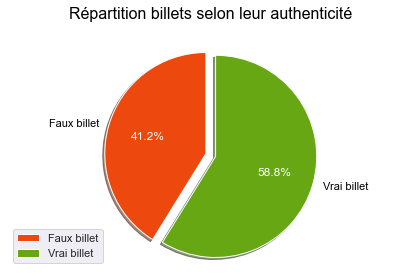

In [13]:
# Répartition des billets
labels = ['Faux billet', 'Vrai billet']
sizes = [70, 100]
# colors = sns.color_palette("", 2)
colors = ['#ed480e', '#66a713']
explode = (0, 0.1)
fig1, ax1 = plt.subplots()
patches, texts, autotexts = ax1.pie(sizes, explode=explode,  labels=labels, 
                                    autopct='%1.1f%%', shadow=True, startangle=90, colors=colors)
for text in texts:
    text.set_color('black')
for autotext in autotexts:
    autotext.set_color('white')
# Equal aspect ratio ensures that pie is drawn as a circle
plt.title('Répartition billets selon leur authenticité\n', color='black', fontsize=16)
ax1.axis('equal')  
plt.tight_layout()

plt.legend(loc ="lower left")
# plt.show()
plt.savefig('Répartition billets selon leur authenticité.jpg')

In [14]:
# type des variables
df_notes.dtypes

is_genuine         bool
diagonal        float64
height_left     float64
height_right    float64
margin_low      float64
margin_up       float64
length          float64
dtype: object

In [15]:
# Valeurs null => pas de valeurs null
df_notes.isnull().sum()

is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64

In [16]:
# Valeurs dupliquées => pas de valeurs dupliquées
df_notes.duplicated().sum()

0

### Mission 0 : brève description des données <a class="anchor" id="mission0"></a>

### Etudes des variables <a class="anchor" id="etude_variables"></a>

### Analyses univariées <a class="anchor" id="etude_univariee"></a>

#### Visualisation des données

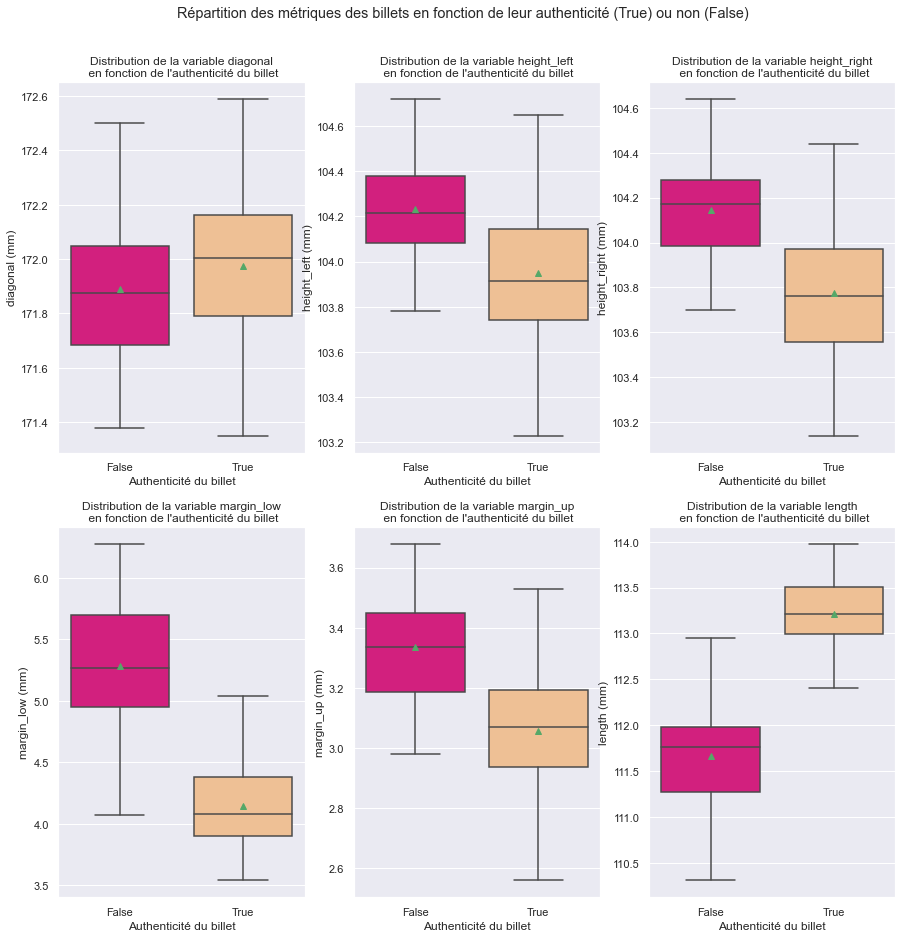

In [17]:
# variables quantitatives 
df_corr_ss_notes = df_notes.drop('is_genuine', axis=1)
v_quanti = df_corr_ss_notes.columns
a = 2  # number of rows
b = 3  # number of columns
c = 1  # initialize plot counter

fig = plt.figure(figsize=(15,15))
fig.suptitle('Répartition des métriques des billets en fonction de leur authenticité (True) ou non (False)',  y=0.95)
for variable in v_quanti:
    
    plt.subplot(a, b, c)
    plt.title('Distribution de la variable {}\n en fonction de l\'authenticité du billet'.format(variable))
    
    sns.boxplot(x='is_genuine', y=variable, data=df_notes, showmeans=True, showfliers=False, palette='Accent_r')
#     plt.title('Répartition des métriques des billets en fonction de leur authenticité (True) ou non (False)', size=14)
    plt.xlabel('Authenticité du billet', size=12)
    plt.ylabel(f'{variable} (mm)', size=12)  
    c += 1
# plt.show()
plt.savefig("Répartition des métriques des billets en fonction de leur authenticité (True) ou non (False).jpg")

Les métriques semblent différer selon l'authenticité du billet. Selon les variables, les métriques semblent plus dispersées.

Remarque sur les vrais billets VS les faux :
- Les vrais billets semblent avoir : 
    - une diagonale plus élevée
    - une height_left plus faible
    - une height_right plus faible
    - une margin_low bcp plus FAIBLE
    - une margin_up plus faible
    - une length bcp plus GRANDE

### Etude chiffrée des vrais billets VS faux billets

In [18]:
# Groupby avec 'is_genuine'
df_notes_auth = df_notes.groupby('is_genuine').mean()
df_notes_auth

,diagonal,height_left,height_right,margin_low,margin_up,length
is_genuine,,,,,,
False,171.889857,104.230429,104.145571,5.281571,3.334571,111.660714
True,171.976100,103.951500,103.775900,4.143500,3.055500,113.207200


### Visualisation des variables avec moyenne et médiane

--------------------
skewness diagonal:
 0.19616651211086614
kurtosis diagonal:
 0.5868437884868345
mode diagonal:
 0    172.1
dtype: float64
var diagonal:
 0.09294435986159198
moy diagonal :
 171.94058823529414
med diagonal :
 171.945
--------------------
skewness height_left:
 0.028648349767483303
kurtosis height_left:
 -0.461713483256764
mode height_left:
 0    104.17
1    104.32
dtype: float64
var height_left:
 0.08839140484429073
moy height_left :
 104.0663529411764
med height_left :
 104.055
--------------------
skewness height_right:
 0.16888595491251637
kurtosis height_right:
 -0.0048842800178983126
mode height_right:
 0    103.76
1    104.06
dtype: float64
var height_right:
 0.10890351557093421
moy height_right :
 103.92811764705884
med height_right :
 103.95
--------------------
skewness margin_low:
 0.5848587605714998
kurtosis margin_low:
 -0.7437861675988664
mode margin_low:
 0    3.97
1    4.08
dtype: float64
var margin_low:
 0.490048456747405
moy margin_low :
 4.612117647

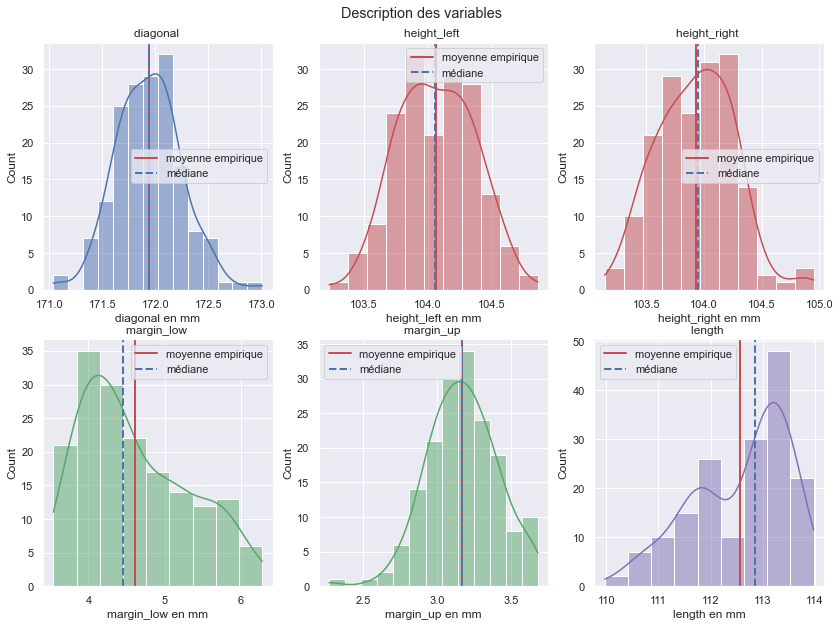

In [19]:
# colors = ['#66a713', 'D0EF08', 'D0EF08',]
colors = ['b', 'r', 'r', 'g', 'g','m']
#  plot Numerical Data
a = 2  # number of rows
b = 3  # number of columns
c = 1  # initialize plot counter

fig, ax = plt.subplots(figsize=(14,10))
fig.suptitle('Description des variables',  y=0.93)
for variable in v_quanti:
  
    plt.subplot(a, b, c)
    plt.title('{} '.format(variable))
    print("-"*20)
    print(f'skewness {variable}:\n',df_corr_ss_notes[variable].skew())
    print(f"kurtosis {variable}:\n",df_corr_ss_notes[variable].kurtosis())
    print(f"mode {variable}:\n",df_corr_ss_notes[variable].mode())
    print(f"var {variable}:\n",df_corr_ss_notes[variable].var(ddof=0))
    print(f"moy {variable} :\n",df_corr_ss_notes[variable].mean())
    print(f"med {variable} :\n",df_corr_ss_notes[variable].median())
    
    plt.xlabel(f'{variable} en mm')
    sns.histplot(data=df_corr_ss_notes, x=variable, kde=True, color=colors[c-1]) 
    plt.axvline(np.mean(df_corr_ss_notes[variable]), color='r', linewidth=2, label='moyenne empirique')
    plt.axvline(np.median(df_corr_ss_notes[variable]), color='b', linewidth=2, linestyle='dashed', label='médiane')
    
    ske = round(df_corr_ss_notes[variable].skew(),2)
    kur = round(df_corr_ss_notes[variable].kurtosis(),2) 
    labels = [ske, kur]
    plt.legend()
    
    c = c + 1

# plt.show()
plt.savefig("Description des variables.jpg")

### Test de normalité des variables

#### Test de Kolmogorov-Smirnov sur les différentes variables afin de tester l’adéquation de ces dernières à une loi normale  et ainsi définir les tests les plus adaptés par la suite
Hypothèses :
- H0 : la variable suit une loi normale
- H1 : la variable ne suit pas une loi normale
- Seuil 5%

In [20]:
for variable in v_quanti :
    print(f'{variable :-<32}{ks_2samp_test(variable, df_corr_ss_notes)}\n') 

p_value :0.9507156199144067
diagonal------------------------HO ne peut pas être rejetée, la variable diagonal suit une loi NORMALE

p_value :0.5782906507294548
height_left---------------------HO ne peut pas être rejetée, la variable height_left suit une loi NORMALE

p_value :0.7034011874211679
height_right--------------------HO ne peut pas être rejetée, la variable height_right suit une loi NORMALE

p_value :0.06891932798225442
margin_low----------------------HO ne peut pas être rejetée, la variable margin_low suit une loi NORMALE

p_value :0.7057707650449323
margin_up-----------------------HO ne peut pas être rejetée, la variable margin_up suit une loi NORMALE

p_value :0.0035492257155427254
length--------------------------HO rejetée, la variable length ne suit pas une loi normale



#### Conclusion : Seule la variable lenght et margin_low ne suivent pas une loi normale au seuil alpha de 0.05

### Test sur la variance sur les variables gaussiennes

#### Test de Levene car plus robuste aux écarts non gaussiens

Hypothèses :
- HO : les variances sont égales
- H1 : les variances ne sont pas égales
- seuil alpha = 0.05

In [21]:
v_quanti_norm = ['diagonal', 'height_left', 'height_right', 'margin_up']
for variable in v_quanti_norm:
    gpe_true = df_notes[df_notes['is_genuine'] == True][variable]
    gpe_false = df_notes[df_notes['is_genuine'] == False][variable]
    print(f'{variable :-<20}{levene_test(gpe_true, gpe_false)}\n') 

p_value :0.6234634322702575
diagonal------------HO ne peut pas être rejetée, les variances des 2 groupes sont égales

p_value :0.03235106500140254
height_left---------HO rejetée, les variances des 2 groupes sont inégales

p_value :0.17085685086245794
height_right--------HO ne peut pas être rejetée, les variances des 2 groupes sont égales

p_value :0.9819024811475876
margin_up-----------HO ne peut pas être rejetée, les variances des 2 groupes sont égales



#### Les H0 des 2 groupes True et False avec les variables "height_left",  "margin_low" et "length" sont rejetées au seuil de 5%.
#### Les groupes sont donc distincts

####  Test de Bartlett

Hypothèses :
- HO : les variances sont égales
- H1 : les variances ne sont pas égales
- seuil alpha = 0.05

In [22]:
for variable in v_quanti_norm:
    gpe_true = df_notes[df_notes['is_genuine'] == True][variable]
    gpe_false = df_notes[df_notes['is_genuine'] == False][variable]
    print(f'{variable :-<20}{bartlett_test(gpe_true, gpe_false)}\n') 

p_value :0.7544170098956573
diagonal------------HO ne peut pas être rejetée, les variances des 2 groupes sont égales

p_value :0.003976965959594022
height_left---------HO rejetée, les variances des 2 groupes sont inégales

p_value :0.19955865324739466
height_right--------HO ne peut pas être rejetée, les variances des 2 groupes sont égales

p_value :0.554794849415443
margin_up-----------HO ne peut pas être rejetée, les variances des 2 groupes sont égales



#### Les H0 des 2 groupes True et False avec les variables "height_left",  "margin_low" et "length" sont rejetées au seuil de 5%.
#### Les groupes sont donc distincts

#### Les tests de Bartlett et Levene arrivent à la même conclusion

### Poursuite de l'étude sur les variables dans les variances sont égales avec un test de Student

### Tests sur les moyennes

#### Test de Student

#### Hypothèses :
- H0 : m4 = m5
- H1 : m4 != m5
- seuil alpha = 0.05

In [23]:
v_quanti_variance = ['diagonal', 'height_right', 'margin_up']
for variable in v_quanti_variance:
        
    gpe_false = df_notes[df_notes['is_genuine'] == False][variable]
# Pour avoir la même dimension d'échatillon
    gpe_true_sample = df_notes[df_notes['is_genuine'] == True][variable].sample(gpe_false.shape[0])
    print(f'{variable :-<20}{student_test(gpe_true_sample, gpe_false)}\n') 

p_value :0.03918108555616233
diagonal------------HO rejetée, les moyennes des 2 groupes sont inégales

p_value :5.241423395449459e-14
height_right--------HO rejetée, les moyennes des 2 groupes sont inégales

p_value :1.1076548245424097e-15
margin_up-----------HO rejetée, les moyennes des 2 groupes sont inégales



#### H0 est rejetée pour les groupes True et False avec la variable "heigth_right" et "margin_up". Les 2 groupes sont distincts.

### En conclusion : Seule la variable diagonal ne permet pas de conclure à la distinction des échantillons True et False

### Analyses bivariées <a class="anchor" id="etude_bivariee"></a>

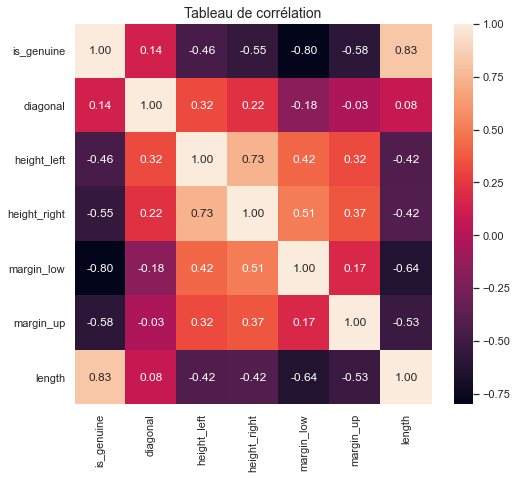

In [24]:
# Corrélation entre les variables
plt.figure(figsize=(8, 7))
sns.heatmap(df_notes.corr(method='pearson'), annot=True, fmt=".2f")
plt.title('Tableau de corrélation', size=14)
plt.savefig('Tableau de corrélation donnees.jpg')
plt.show()


Remarques corrélation :
- height_left avec height_right (0.73)
- margin_low avec length (0.64)
- margin_up avec length (0.53)
- margin_low avec height_right (0.51)

<Figure size 720x720 with 0 Axes>

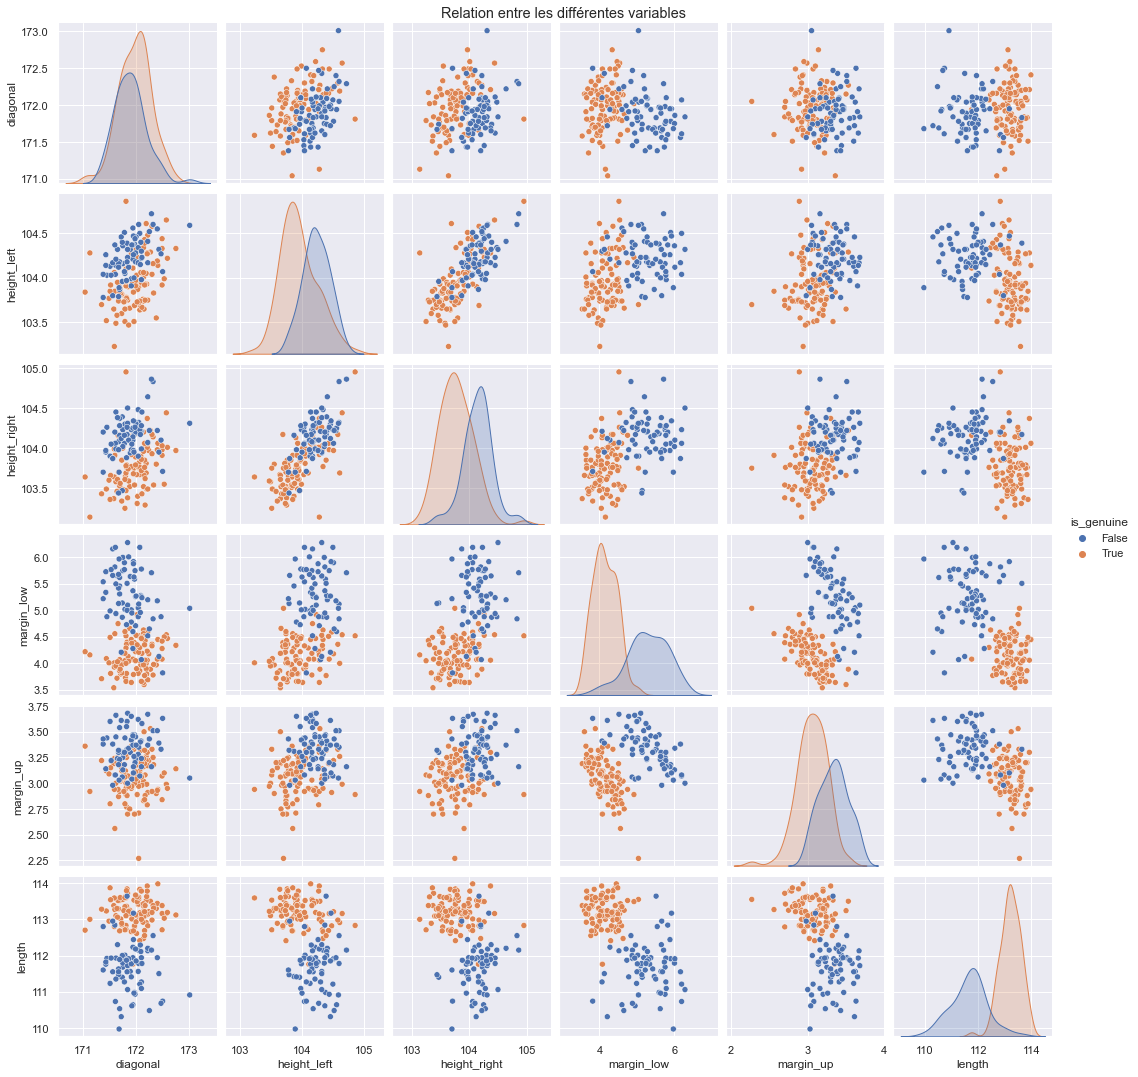

In [25]:
plt.figure(figsize=(10,10))
sns.pairplot(df_notes, hue='is_genuine')
plt.suptitle('Relation entre les différentes variables', y=1)
# plt.show()
plt.savefig('pairplot données.jpg', format='jpg')

Un billet authentique semble avoir (par rapport à un faux):
 - une 'margin_low'et une 'margin_up' plus petite
 - une 'length' plus grande
 - une 'height_right' et une 'height_left'

Un billet authentique semble se distinguer **facilement** d'un faux par :
- sa 'margin_low'
- sa 'length'

### ANOVA  <a class="anchor" id="anova"></a>

#### Etude de corrélations des variables (qual et quant ) avec le calcul de eta_squared (rapport de corrélation)

In [26]:
# X : var qual
# Y : var quant
for variable in v_quanti:
    print(f'eta_squared {variable} :', eta_squared(df_notes,'is_genuine',variable))

eta_squared diagonal : 0.019383108567093802
eta_squared height_left : 0.21319458315018705
eta_squared height_right : 0.30394154672012125
eta_squared margin_low : 0.640177214288775
eta_squared margin_up : 0.3396567096032002
eta_squared length : 0.6818507654957807


Rappel : 
 - eta_squared = 0 => pas de corrélation entre les 2 variables (is_genuine et métriques considérée) car moyennes par métriques (variables) sont toutes identiques (variation interclasse = 0)
 - eta_squared = 1 => corrélation forte entre les 2 variables (moyennes par métriques différentes donc relation entre is_genuine et métriques)

Conclusion :
- Forte corrélation entre l'**authenticité** et **length** pareil avec **margin_low**
- Pas de corrélation entre l'**authenticité** et **diagonal**

### Juste pour voir ... <a class="anchor" id="juste_voir"></a>

#### Visualisation fixe et animée de la régression linéaire 'height_right' et une 'height_left'

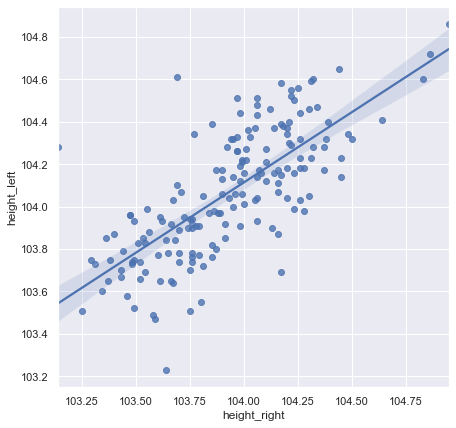

In [27]:
plt.figure(figsize=(7,7))
sns.regplot(x="height_right", y="height_left", data=df_notes);

#### Visualisation animée <a class="anchor" id="reg_linéaire_animee"></a>

In [28]:
%matplotlib notebook

<IPython.core.display.Javascript object>


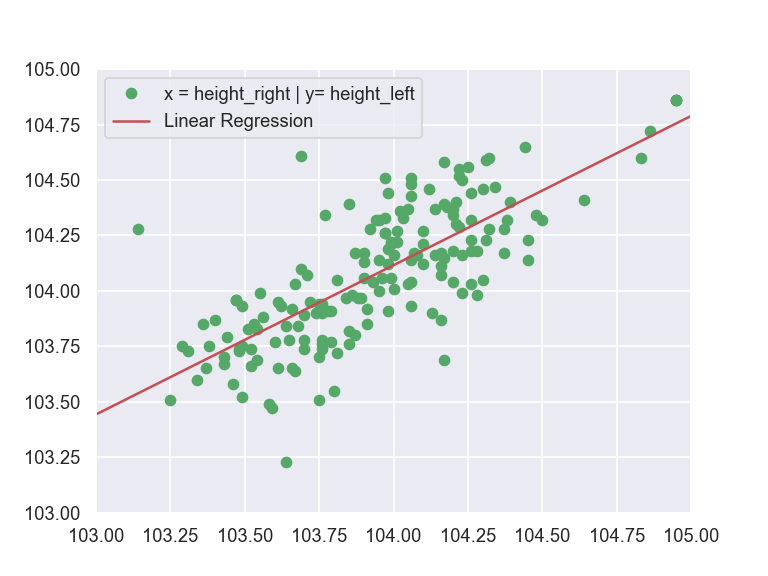

In [30]:
x = df_notes.height_right.to_numpy().reshape(-1,1)
y = df_notes.height_left.to_numpy().reshape(-1,1)

x_data = []
y_data = []

fig, ax = plt.subplots()     # A tuple unpacking to unpack the only fig
ax.set_xlim(103, 105)
ax.set_ylim(103, 105)
# Plotting 
scatter, = ax.plot([], [], 'go', label='x = height_right | y= height_left')
line, = ax.plot([], [], 'r', label='Linear Regression')
ax.legend()

reg = LinearRegression()

def animate(frame_num):
    # Adding data
    x_data.append(x[frame_num])
    y_data.append(y[frame_num])
    # Convert data to numpy array
    x_train = np.array(x_data).reshape(-1, 1)
    y_train = np.array(y_data).reshape(-1, 1)
    # Fit values to a linear regression
    reg.fit(x_train, y_train)

    # update data for scatter plot
    scatter.set_data((x_data, y_data))
    # Predict value and update data for line plot
    line.set_data((list(range(120)), reg.predict(np.array([entry for entry in range(120)]).reshape(-1, 1))))

anim = FuncAnimation(fig, animate, frames=len(x), interval=20)
plt.show()